In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import random
from tqdm import tqdm
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration, mass_defs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from pylab import rcParams
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams['font.family'] = 'serif'
rc('text.latex',preamble=r'\usepackage{/Volumes/Extreme_SSD/codes/master_thesis/code/configs/apjfonts}')
from matplotlib.lines import Line2D
from cosmo import CosmoCalc
import sims
import foregrounds as fg
import experiments as exp
import tools
import lensing_estimator

## Effect of Filters

In [5]:
nber_rand = 1
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
cluster = [9e15, 3, 1]
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.4)
l, nl = exp.white_noise_power_spectrum(noiseval_white = 2.0)
cmb_map = sims.cmb_mock_data(map_params, l, cl, cluster = cluster, bl = bl, nl = nl)
l, nl_deconvolved =  exp.white_noise_power_spectrum(noiseval_white = 2.0, beam_fwhm = 1.4)
cl_noise = nl_deconvolved
wiener_filter = tools.wiener_filter(l, cl, cl_noise)
cmb_map_wiener_filtered = tools.convolve(cmb_map, l, wiener_filter, map_params = map_params) 
low_pass_filter = tools.low_pass_filter(l,  2000)
cmb_map_low_pass_filtered = tools.convolve(cmb_map_wiener_filtered, l, low_pass_filter, map_params = map_params) 

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:98: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:117: RuntimeWarning: divide by zero encountered in arctanh
  f[x3] = (1/np.sqrt(1-x[x3]**2))*np.arctanh(np.sqrt(1-x[x3]**2))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:45: RuntimeWarning: invalid value encountered in true_divide
  alphaX_fft =  1j * lX * 2. *  kappa_map_fft / l2d**2
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:46: RuntimeWarning: invalid value encountered in true_divide
  alphaY_fft =  1j * lY * 2. *  kappa_map_fft / l2d**2


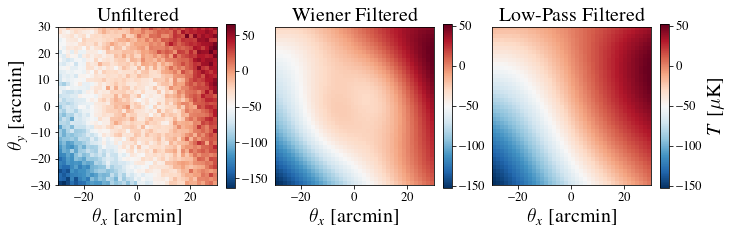

In [6]:
_, extent = tools.make_grid(map_params)
fig, ax = plt.subplots(1,3, figsize=(10,10))
sz = 20

im0 = ax[0].imshow(cmb_map[100:140, 100:140], extent = extent, cmap = cm.RdBu_r)
cb0 = fig.colorbar(im0, ax = ax[0], shrink = 0.228)
cb0.ax.tick_params(labelsize=sz-7)
ax[0].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = sz)
ax[0].set_ylabel(r'$\theta_y\ $'+'[arcmin]', fontsize = sz)
ax[0].set_title('Unfiltered', fontsize = sz)
ax[0].tick_params(labelsize = sz-7)

im1 = ax[1].imshow(cmb_map_wiener_filtered[100:140, 100:140], extent = extent, cmap = cm.RdBu_r)
cb1 = fig.colorbar(im1, ax = ax[1], shrink = 0.228)
cb1.ax.tick_params(labelsize=sz-7)
ax[1].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = sz)
ax[1].set_ylabel(r'$\theta_y\ $'+'[arcmin]', fontsize = sz)
ax[1].set_title('Wiener Filtered', fontsize = sz)
ax[1].get_yaxis().set_visible(False)
ax[1].tick_params(labelsize = sz-7)


im2 = ax[2].imshow(cmb_map_low_pass_filtered[100:140, 100:140], extent = extent, cmap = cm.RdBu_r)
cb2 = fig.colorbar(im1, ax = ax[2], shrink = 0.228)
cb2.set_label(label=r'$T \ [\mu$'+'K]', size=sz)
cb2.ax.tick_params(labelsize=sz-7)
ax[2].set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = sz)
ax[2].set_ylabel(r'$\theta_y\ $'+'[arcmin]', fontsize = sz)
ax[2].set_title('Low-Pass Filtered', fontsize = sz)
ax[2].get_yaxis().set_visible(False)
ax[2].tick_params(labelsize = sz-7)


fig.tight_layout(pad=0)
fig.savefig('effect_of_filters.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

## Pipeline

In [ ]:
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, c200c = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
cluster = [M200c, c200c, 0.7]
fname = '/Volumes/Extreme_SSD/codes/master_thesis/code/data/mdpl2_cutouts_for_tszksz_clus_detection_M1.7e+14to2.3e+14_z0.6to0.8_15320haloes_boxsize20.0am.npz'
cutouts_dic = np.load(fname, allow_pickle = 1, encoding= 'latin1')['arr_0'].item()
mass_z_key = list(cutouts_dic.keys())[0]
cutouts = cutouts_dic[mass_z_key]
scale_fac = fg.compton_y_to_delta_Tcmb(freq = 145, uK = True)
tsz_ksz_cutouts = []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout = cutouts[keyname]['y']*scale_fac
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    tsz_ksz_cutout = tsz_cutout + ksz_cutout
    tsz_ksz_cutouts.append(tsz_ksz_cutout)  

maps_clus =[]
for i in tqdm(range(30000)):
    map_clus = sims.cmb_mock_data(map_params, l, cl, cluster = cluster)
    maps_clus.append(map_clus)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/data/maps_clus_baseline_chapter4.npy', 'wb') as file:
    np.save(file, maps_clus)  

In [ ]:
maps_rand =[]
for i in tqdm(range(30000)):
    map_rand = sims.cmb_mock_data(map_params, l, cl)
    maps_rand.append(map_rand)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/data/maps_rand_chapter4.npy', 'wb') as file:
    np.save(file, maps_rand)  

In [9]:
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/data/maps_clus_tsz_ksz_chapter4.npy', 'rb') as file:
    maps_clus = np.load(file) 

#with open('/Volumes/Extreme_SSD/codes/master_thesis/code/data/maps_rand_chapter4.npy', 'rb') as file:
#    maps_rand = np.load(file) 

In [10]:
bins, prof, stacks = lensing_estimator.lensing_dipole_profile(map_params, maps_clus, maps_rand, correct_for_tsz = True)
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_clus_tsz_ksz_30000_chapter4.npy', 'wb') as file:
    np.save(file, stacks[0])    
#with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_30000_chapter4.npy', 'wb') as file:
#    np.save(file, stacks[1])   
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_tsz_30000_chapter4.npy', 'wb') as file:
    np.save(file, stacks[3])  

100%|██████████| 30000/30000 [01:35<00:00, 313.15it/s]


In [72]:
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, c200c = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
cluster = [M200c, c200c, 0.7]

cutouts_clus = []
cutouts_clus_aligned = []
for i in range(3):
    map_clus = sims.cmb_mock_data(map_params, l, cl, cluster = cluster)
    cutout = tools.central_cutout(map_params, map_clus, 10)
    cutout -= np.median(cutout)
    cutouts_clus.append(cutout)
    cutouts_clus_aligned.append(lensing_estimator.get_aligned_cutout(map_params, map_clus)[0])

cutouts_rand = []
cutouts_rand_aligned = []
for i in range(3):
    map_rand = sims.cmb_mock_data(map_params, l, cl)
    cutout = tools.central_cutout(map_params, map_rand, 10)
    cutout -= np.median(cutout)
    cutouts_rand.append(cutout)
    cutouts_rand_aligned.append(lensing_estimator.get_aligned_cutout(map_params, map_rand)[0])
    
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_clus_baseline_30000_chapter4.npy', 'rb') as file:
    stack_clus_baseline = np.load(file)    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_30000_chapter4.npy', 'rb') as file:
    stack_bg = np.load(file) 
stack_dipole_baseline = stack_clus_baseline-stack_bg
_, dx, _, _ = map_params
bins = np.arange((-40*dx)/2, (40*dx)/2, dx)
lensing_dipole_profile_baseline = np.mean(stack_dipole_baseline, axis = 0)

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:98: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:117: RuntimeWarning: divide by zero encountered in arctanh
  f[x3] = (1/np.sqrt(1-x[x3]**2))*np.arctanh(np.sqrt(1-x[x3]**2))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:45: RuntimeWarning: invalid value encountered in true_divide
  alphaX_fft =  1j * lX * 2. *  kappa_map_fft / l2d**2
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:46: RuntimeWarning: invalid value encountered in true_divide
  alphaY_fft =  1j * lY * 2. *  kappa_map_fft / l2d**2


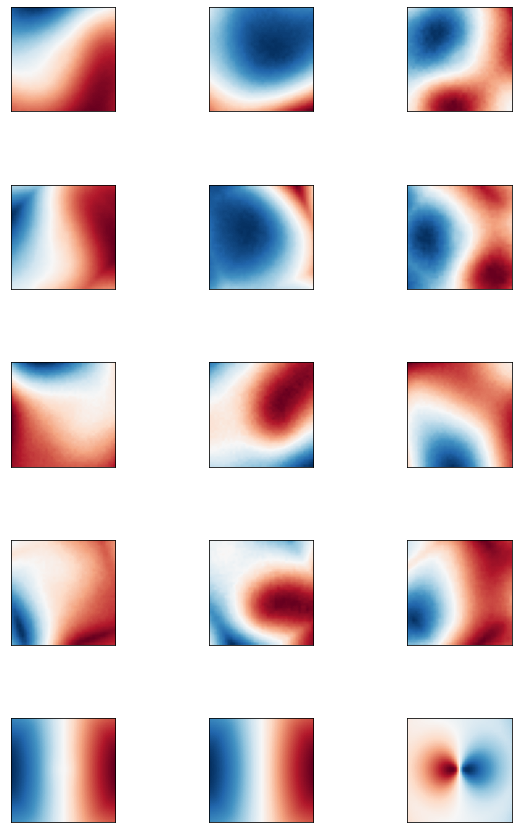

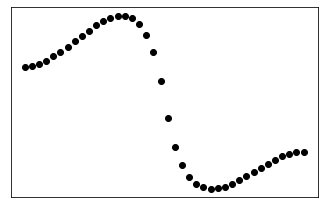

In [73]:
_, extent = tools.make_grid([40, 0.25, 40, 0.25])
fig, axarr = plt.subplots(5,3, figsize=(15,15))


img00 = axarr[0,0].imshow(cutouts_clus[0], extent = extent, cmap = cm.RdBu_r)
axarr[0,0].get_xaxis().set_visible(False)
axarr[0,0].get_yaxis().set_visible(False)
img01 = axarr[0,1].imshow(cutouts_clus[1], extent = extent, cmap = cm.RdBu_r)
axarr[0,1].get_xaxis().set_visible(False)
axarr[0,1].get_yaxis().set_visible(False)
img02 = axarr[0,2].imshow(cutouts_clus[2], extent = extent, cmap = cm.RdBu_r)
axarr[0,2].get_xaxis().set_visible(False)
axarr[0,2].get_yaxis().set_visible(False)


img10 = axarr[1,0].imshow(cutouts_clus_aligned[0], extent = extent, cmap = cm.RdBu_r)
axarr[1,0].get_xaxis().set_visible(False)
axarr[1,0].get_yaxis().set_visible(False)
img11 = axarr[1,1].imshow(cutouts_clus_aligned[1], extent = extent, cmap = cm.RdBu_r)
axarr[1,1].get_xaxis().set_visible(False)
axarr[1,1].get_yaxis().set_visible(False)
img12 = axarr[1,2].imshow(cutouts_clus_aligned[2], extent = extent, cmap = cm.RdBu_r)
axarr[1,2].get_xaxis().set_visible(False)
axarr[1,2].get_yaxis().set_visible(False)


img20 = axarr[2,0].imshow(cutouts_rand[0], extent = extent, cmap = cm.RdBu_r)
axarr[2,0].get_xaxis().set_visible(False)
axarr[2,0].get_yaxis().set_visible(False)
img21 = axarr[2,1].imshow(cutouts_rand[1], extent = extent, cmap = cm.RdBu_r)
axarr[2,1].get_xaxis().set_visible(False)
axarr[2,1].get_yaxis().set_visible(False)
img22 = axarr[2,2].imshow(cutouts_rand[2], extent = extent, cmap = cm.RdBu_r)
axarr[2,2].get_xaxis().set_visible(False)
axarr[2,2].get_yaxis().set_visible(False)



img30 = axarr[3,0].imshow(cutouts_rand_aligned[0], extent = extent, cmap = cm.RdBu_r)
axarr[3,0].get_xaxis().set_visible(False)
axarr[3,0].get_yaxis().set_visible(False)
img31 = axarr[3,1].imshow(cutouts_rand_aligned[1], extent = extent, cmap = cm.RdBu_r)
axarr[3,1].get_xaxis().set_visible(False)
axarr[3,1].get_yaxis().set_visible(False)
img32 = axarr[3,2].imshow(cutouts_rand_aligned[2], extent = extent, cmap = cm.RdBu_r)
axarr[3,2].get_xaxis().set_visible(False)
axarr[3,2].get_yaxis().set_visible(False)


img40 = axarr[4,0].imshow(stack_clus_baseline, extent = extent, cmap = cm.RdBu_r)
axarr[4,0].get_xaxis().set_visible(False)
axarr[4,0].get_yaxis().set_visible(False)
img41 = axarr[4,1].imshow(stack_bg, extent = extent, cmap = cm.RdBu_r)
axarr[4,1].get_xaxis().set_visible(False)
axarr[4,1].get_yaxis().set_visible(False)
img42 = axarr[4,2].imshow(stack_dipole_baseline, extent = extent, cmap = cm.RdBu_r)
axarr[4,2].get_xaxis().set_visible(False)
axarr[4,2].get_yaxis().set_visible(False)

fig.subplots_adjust(wspace= -0.55, hspace = 0.7)

plt.savefig('figures/pipeline_cutouts_baseline.png')



fig, ax = plt.subplots(1,1, figsize=(5.5,3.5))
ax.plot(bins, lensing_dipole_profile_baseline, color = 'black', ls = '', marker = 'o')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


plt.savefig('figures/pipeline_profile_baseline.png')

In [43]:
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, c200c = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
cluster = [M200c, c200c, 0.7]
fname = '/Volumes/Extreme_SSD/codes/master_thesis/code/data/mdpl2_cutouts_for_tszksz_clus_detection_M1.7e+14to2.3e+14_z0.6to0.8_15320haloes_boxsize20.0am.npz'
cutouts_dic = np.load(fname, allow_pickle = 1, encoding= 'latin1')['arr_0'].item()
mass_z_key = list(cutouts_dic.keys())[0]
cutouts = cutouts_dic[mass_z_key]
scale_fac = fg.compton_y_to_delta_Tcmb(freq = 145, uK = True)
tsz_ksz_cutouts = []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout = cutouts[keyname]['y']*scale_fac
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    tsz_ksz_cutout = tsz_cutout + ksz_cutout
    tsz_ksz_cutouts.append(tsz_ksz_cutout)  


cutouts_clus = []
cutouts_clus_aligned = []
for i in range(3):
    map_clus = sims.cmb_mock_data(map_params, l, cl, cluster = cluster, cluster_corr_cutouts = tsz_ksz_cutouts)
    cutout = tools.central_cutout(map_params, map_clus, 10)
    cutout -= np.median(cutout)
    cutouts_clus.append(cutout)
    cutouts_clus_aligned.append(lensing_estimator.get_aligned_cutout(map_params, map_clus)[0])

cutouts_rand = []
cutouts_rand_aligned = []
for i in range(3):
    map_rand = sims.cmb_mock_data(map_params, l, cl)
    cutout = tools.central_cutout(map_params, map_rand, 10)
    cutout -= np.median(cutout)
    cutouts_rand.append(cutout)
    cutouts_rand_aligned.append(lensing_estimator.get_aligned_cutout(map_params, map_rand)[0])
    
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_clus_tsz_ksz_30000_chapter4.npy', 'rb') as file:
    stack_clus_tsz_ksz = np.load(file)    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_30000_chapter4.npy', 'rb') as file:
    stack_bg = np.load(file) 
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_tsz_30000_chapter4.npy', 'rb') as file:
    stack_tsz = np.load(file)   
stack_dipole_tsz_ksz = stack_clus_tsz_ksz-stack_bg-stack_tsz
_, dx, _, _ = map_params
bins = np.arange((-40*dx)/2, (40*dx)/2, dx)
lensing_dipole_profile_tsz_ksz = np.mean(stack_dipole_tsz_ksz, axis = 0)

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:98: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:117: RuntimeWarning: divide by zero encountered in arctanh
  f[x3] = (1/np.sqrt(1-x[x3]**2))*np.arctanh(np.sqrt(1-x[x3]**2))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:45: RuntimeWarning: invalid value encountered in true_divide
  alphaX_fft =  1j * lX * 2. *  kappa_map_fft / l2d**2
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:46: RuntimeWarning: invalid value encountered in true_divide
  alphaY_fft =  1j * lY * 2. *  kappa_map_fft / l2d**2


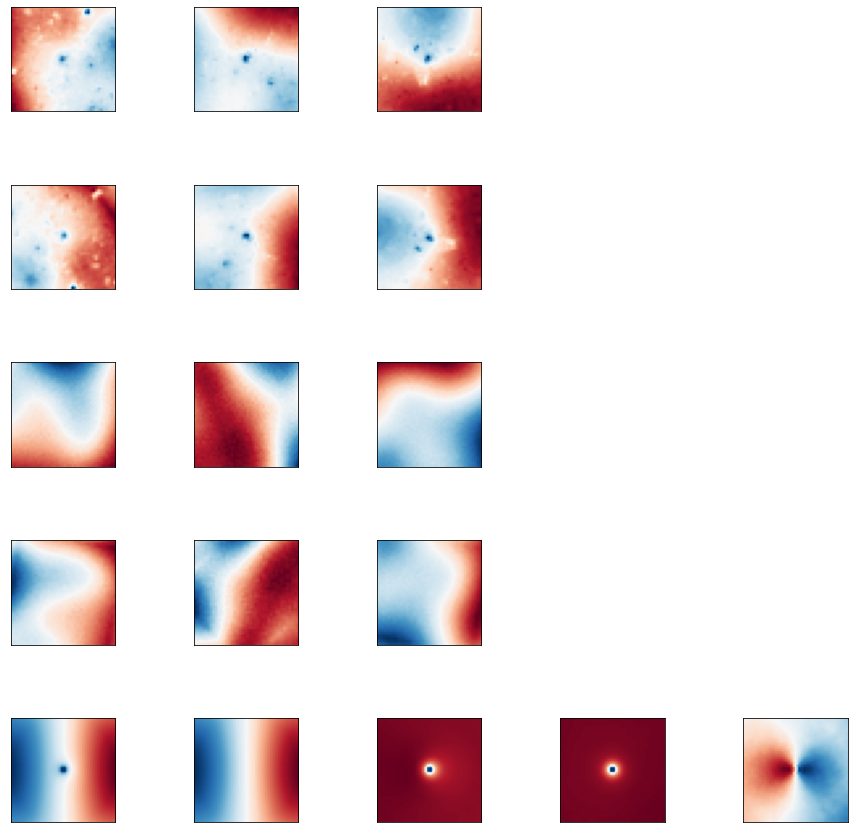

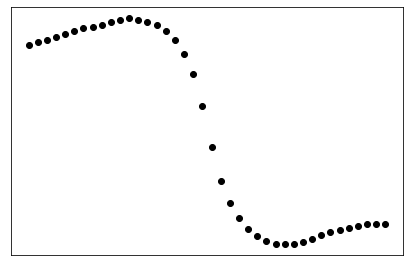

In [71]:
_, extent = tools.make_grid([40, 0.25, 40, 0.25])
fig, axarr = plt.subplots(5,5, figsize=(15,15))


img00 = axarr[0,0].imshow(cutouts_clus[0], extent = extent, cmap = cm.RdBu_r)
axarr[0,0].get_xaxis().set_visible(False)
axarr[0,0].get_yaxis().set_visible(False)
img01 = axarr[0,1].imshow(cutouts_clus[1], extent = extent, cmap = cm.RdBu_r)
axarr[0,1].get_xaxis().set_visible(False)
axarr[0,1].get_yaxis().set_visible(False)
img02 = axarr[0,2].imshow(cutouts_clus[2], extent = extent, cmap = cm.RdBu_r)
axarr[0,2].get_xaxis().set_visible(False)
axarr[0,2].get_yaxis().set_visible(False)
axarr[0,3].set_visible(False)
axarr[0,4].set_visible(False)

img10 = axarr[1,0].imshow(cutouts_clus_aligned[0], extent = extent, cmap = cm.RdBu_r)
axarr[1,0].get_xaxis().set_visible(False)
axarr[1,0].get_yaxis().set_visible(False)
img11 = axarr[1,1].imshow(cutouts_clus_aligned[1], extent = extent, cmap = cm.RdBu_r)
axarr[1,1].get_xaxis().set_visible(False)
axarr[1,1].get_yaxis().set_visible(False)
img12 = axarr[1,2].imshow(cutouts_clus_aligned[2], extent = extent, cmap = cm.RdBu_r)
axarr[1,2].get_xaxis().set_visible(False)
axarr[1,2].get_yaxis().set_visible(False)
axarr[1,3].set_visible(False)
axarr[1,4].set_visible(False)

img20 = axarr[2,0].imshow(cutouts_rand[0], extent = extent, cmap = cm.RdBu_r)
axarr[2,0].get_xaxis().set_visible(False)
axarr[2,0].get_yaxis().set_visible(False)
img21 = axarr[2,1].imshow(cutouts_rand[1], extent = extent, cmap = cm.RdBu_r)
axarr[2,1].get_xaxis().set_visible(False)
axarr[2,1].get_yaxis().set_visible(False)
img22 = axarr[2,2].imshow(cutouts_rand[2], extent = extent, cmap = cm.RdBu_r)
axarr[2,2].get_xaxis().set_visible(False)
axarr[2,2].get_yaxis().set_visible(False)
axarr[2,3].set_visible(False)
axarr[2,4].set_visible(False)

img30 = axarr[3,0].imshow(cutouts_rand_aligned[0], extent = extent, cmap = cm.RdBu_r)
axarr[3,0].get_xaxis().set_visible(False)
axarr[3,0].get_yaxis().set_visible(False)
img31 = axarr[3,1].imshow(cutouts_rand_aligned[1], extent = extent, cmap = cm.RdBu_r)
axarr[3,1].get_xaxis().set_visible(False)
axarr[3,1].get_yaxis().set_visible(False)
img32 = axarr[3,2].imshow(cutouts_rand_aligned[2], extent = extent, cmap = cm.RdBu_r)
axarr[3,2].get_xaxis().set_visible(False)
axarr[3,2].get_yaxis().set_visible(False)
axarr[3,3].set_visible(False)
axarr[3,4].set_visible(False)


img40 = axarr[4,0].imshow(stack_clus_tsz_ksz, extent = extent, cmap = cm.RdBu_r)
axarr[4,0].get_xaxis().set_visible(False)
axarr[4,0].get_yaxis().set_visible(False)
img41 = axarr[4,1].imshow(stack_bg, extent = extent, cmap = cm.RdBu_r)
axarr[4,1].get_xaxis().set_visible(False)
axarr[4,1].get_yaxis().set_visible(False)
img42 = axarr[4,2].imshow(stack_clus_tsz_ksz-stack_bg, extent = extent, cmap = cm.RdBu_r)
axarr[4,2].get_xaxis().set_visible(False)
axarr[4,2].get_yaxis().set_visible(False)
img43 = axarr[4,3].imshow(stack_tsz, extent = extent, cmap = cm.RdBu_r)
axarr[4,3].get_xaxis().set_visible(False)
axarr[4,3].get_yaxis().set_visible(False)
img44 = axarr[4,4].imshow(stack_dipole_tsz_ksz, extent = extent, cmap = cm.RdBu_r)
axarr[4,4].get_xaxis().set_visible(False)
axarr[4,4].get_yaxis().set_visible(False)

fig.subplots_adjust(wspace= 0.75, hspace = 0.7)

plt.savefig('figures/pipeline_cutouts_tsz_ksz.png')

fig, ax = plt.subplots(1,1, figsize=(5.5,3.5))
ax.plot(bins, lensing_dipole_profile_tsz_ksz, color = 'black', ls = '', marker = 'o')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.tight_layout(pad=0)
plt.savefig('figures/pipeline_profile_tsz_ksz.png')

## Number of Maps for Fitting

In [ ]:
map_params = [240, 0.25, 240, 0.25]
l, cl = CosmoCalc().cmb_power_spectrum()
cluster = [6e14, 3, 1]

with open('/Volumes/Extreme_SSD/codes/master_thesis/code/data/maps_rand_chapter4.npy', 'rb') as file:
    maps_rand = np.load(file) 

lensing_dipole_profiles_1000 = []
for i in range(25):
    maps_clus = []
    for j in range(1000):
        map_clus = sims.cmb_mock_data(map_params, l, cl, cluster = cluster)
        maps_clus.append(map_clus)
    bins, lensing_dipole_profile, stacks = lensing_estimator.lensing_dipole_profile(map_params, maps_clus, maps_rand)
    lensing_dipole_profiles_1000.append(lensing_dipole_profile) 

with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lensing_dipole_profiles_1000_chapter4.npy', 'wb') as file:
    np.save(file, lensing_dipole_profiles_1000) 

In [ ]:
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lensing_dipole_profiles_1000_chapter4.npy', 'rb') as file:
    lensing_dipole_profiles_1000 = np.load(file) 



In [ ]:
fig, axs = plt.subplots(2, 2, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(9,6))
sz = 20

(ax1, ax2), (ax3, ax4) = axs
for i in range(24):
    ax1.plot(bins, lensing_dipole_profiles_1000[i], color = 'red', alpha = 0.1)
ax1.plot(bins, dipole_profiles_1000[24], color = 'red', alpha = 0.1, label = nber_clusters_int[0])
ax1.plot(bins, np.mean(dipole_profiles_1000, axis = 0), color = 'green', ls = '--', label = nber_clusters_int[0])
ax1.set_ylabel(r'$\langle\Delta T_{\theta_x}\rangle$'+r'$\ [\mu$'+'K]', fontsize = sz)
ax1.tick_params(labelsize = sz-6)
ax1.legend(ncol = 1, prop={'size': sz-6})
for i in range(24):
    ax2.plot(bins, lensing_dipole_profiles_10000[i], color = 'red', alpha = 0.1)
ax2.plot(bins, dipole_profiles_10000[24], color = 'red', alpha = 0.1, label = nber_clusters_int[1])
ax2.plot(bins, np.mean(dipole_profiles_10000, axis = 0), color = 'green', ls = '--')
ax2.tick_params(labelsize = sz-6)
ax2.legend(ncol = 1, prop={'size': sz-6})
for i in range(24):
    ax3.plot(bins, lensing_dipole_profiles_20000[i], color = 'red', alpha = 0.1)
ax3.plot(bins, dipole_profiles_20000[24], color = 'red', alpha = 0.1, label = nber_clusters_int[2])
ax3.plot(bins, np.mean(dipole_profiles_20000, axis = 0), color = 'green', ls = '--')
ax3.set_xlabel(r'$\theta_x$ [arcmin]', fontsize = sz)
ax3.set_ylabel(r'$\langle\Delta T_{\theta_x}\rangle$'+r'$\ [\mu$'+'K]', fontsize = sz)
ax3.set_xticks([-4,-2,0,2, 4])
ax3.tick_params(labelsize = sz-6)
ax3.legend(ncol = 1, prop={'size': sz-6})
for i in range(24):
    ax4.plot(bins, lensing_dipole_profiles_30000[i], color = 'red', alpha = 0.1)
ax4.plot(bins, dipole_profiles_30000[24], color = 'red', alpha = 0.1, label = nber_clusters_int[3])
ax4.plot(bins, np.mean(dipole_profiles_40000, axis = 0), color = 'green', ls = '--')
ax4.set_xlabel(r'$\theta_x$ [arcmin]', fontsize = sz)
ax4.set_xticks([-4,-2,0,2, 4])
ax4.tick_params(labelsize = sz-6)
ax4.legend(ncol = 1, prop={'size': sz-6})

fig.savefig('number_of_maps_for_fitting.eps', dpi = 200.)